In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

import cv2
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from pathlib import Path
import time 
from tqdm import tqdm
from glob import glob
import zipfile
import shutil


In [2]:
!git clone https://github.com/soniamartinot/MVA-Dose-Prediction.git

Cloning into 'MVA-Dose-Prediction'...
remote: Enumerating objects: 38724, done.
remote: Total 38724 (delta 0), reused 0 (delta 0), pack-reused 38724
Receiving objects: 100% (38724/38724), 77.02 MiB | 31.60 MiB/s, done.
Resolving deltas: 100% (30603/30603), done.
Updating files: 100% (39600/39600), done.


In [3]:
class config:
    TRAIN_PATH = "/kaggle/working/MVA-Dose-Prediction/train"
    TEST_PATH = "/kaggle/working/MVA-Dose-Prediction/test"
    VAL_PATH = "/kaggle/working/MVA-Dose-Prediction/validation"

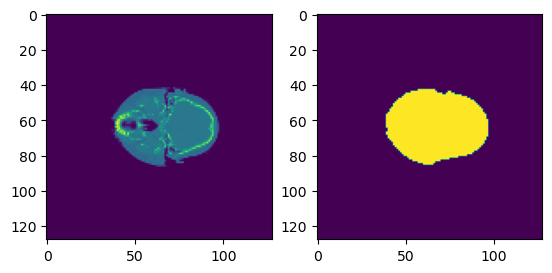

In [18]:
path_ct = Path(config.TRAIN_PATH) / "sample_0/ct.npy"
path_possible_dose= Path(config.TRAIN_PATH) / "sample_0/possible_dose_mask.npy"

img_ct = np.load(path_ct)
img_mask = np.load(path_possible_dose)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_ct)
ax[1].imshow(img_mask)
plt.show()

In [22]:
train_dir = Path(config.TRAIN_PATH)

['/kaggle/working/MVA-Dose-Prediction/train/sample_0',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_10',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_100',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1000',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1001',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1002',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1003',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1004',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1005',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1006',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1007',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1008',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1009',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_101',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1010',
 '/kaggle/working/MVA-Dose-Prediction/train/sample_1011',
 '/kaggle/working/MVA-Do

### Augmentation on single image

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


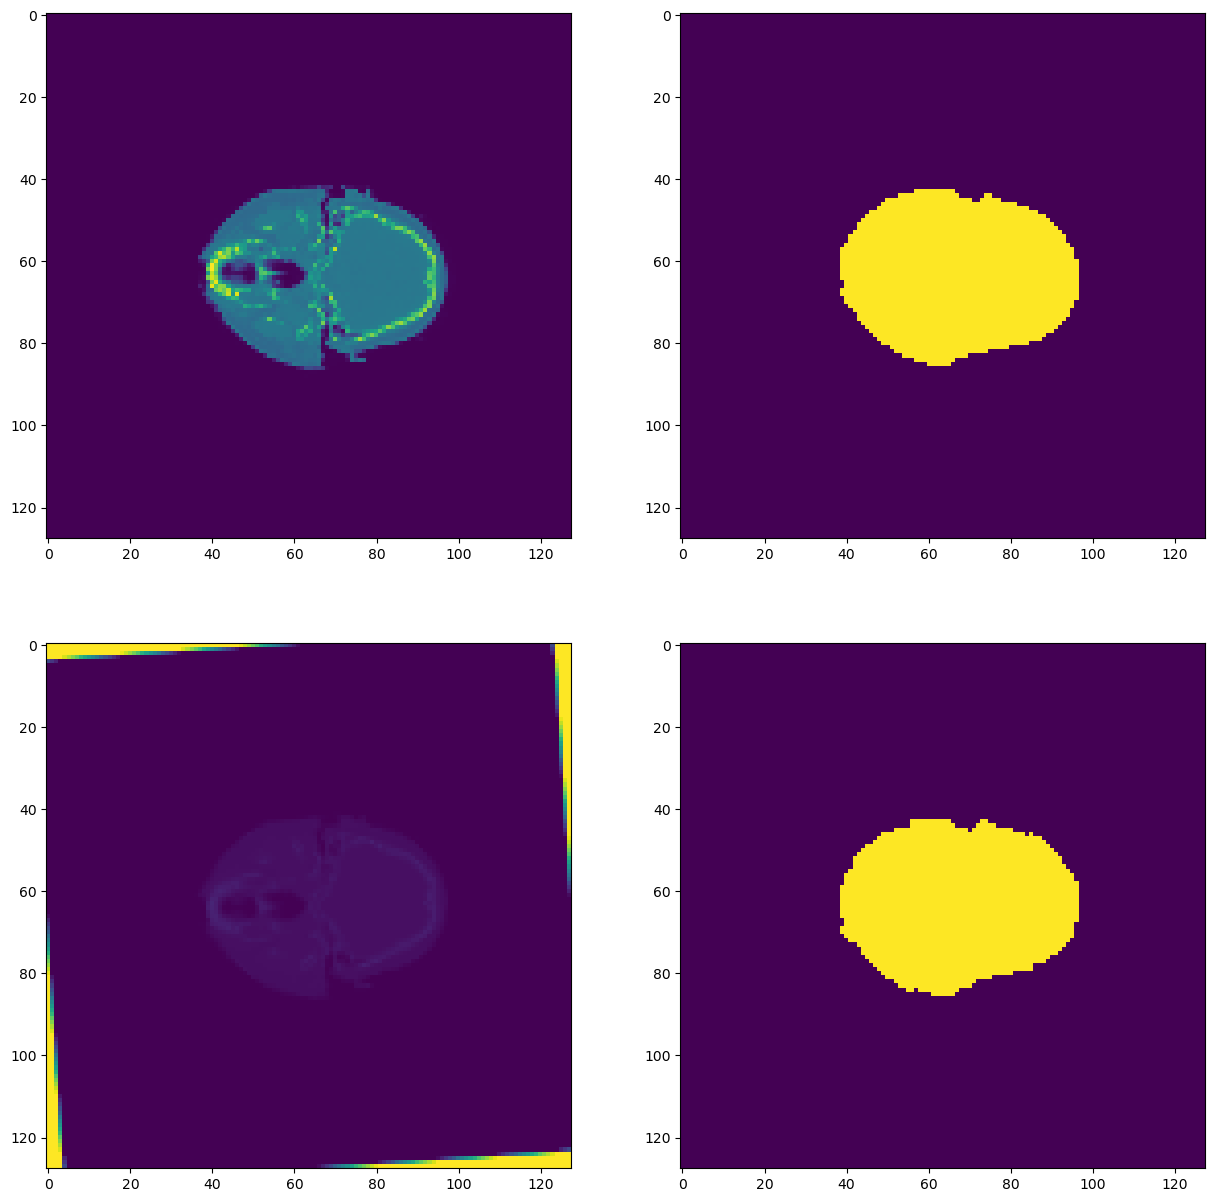

In [55]:
import cv2 
import albumentations as A

# Image and mask 
index = 0

img_paths =[dir for dir in train_dir.iterdir()if dir.is_dir()]
files_path = sorted(img_paths)

ct_path = files_path[index] / "ct.npy"
mask_path = files_path[index] / "possible_dose_mask.npy"

ct = np.load(ct_path)
mask = np.load(mask_path)

# Transformation
transform = A.Compose(
    [
        A.Normalize(mean=[97.6], std=[314.5], max_pixel_value=255),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
    ]
)
print(type(ct))
print(type(mask))


# Applying the transformations
augmentations = transform(image=ct, masks=[mask])
augmented_ct = augmentations["image"]
augmented_masks = augmentations["masks"]

fig, ax = plt.subplots(2,2,figsize=(15, 15))
ax[0][0].imshow(ct)
ax[1][0].imshow(augmented_ct)
ax[0][1].imshow(mask)
ax[1][1].imshow(augmented_masks[0])
plt.show()


### For many images

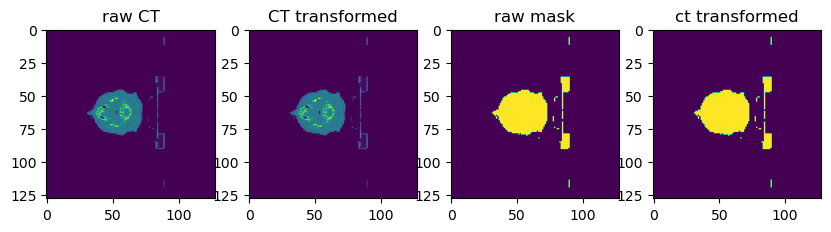

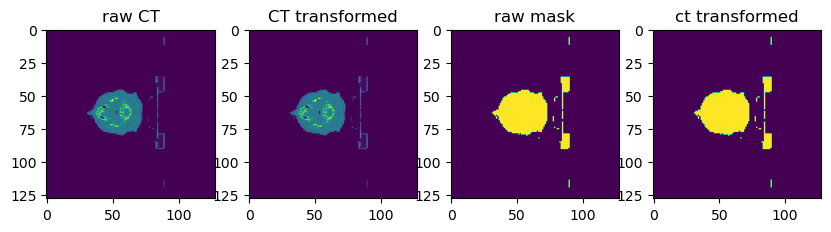

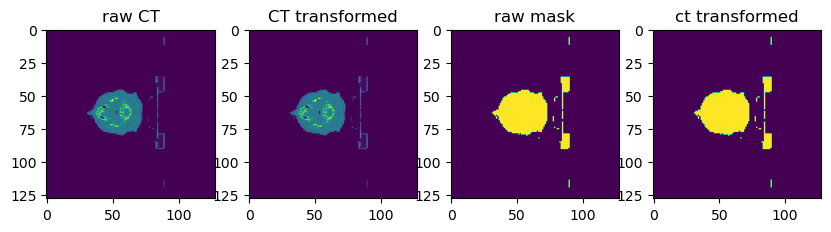

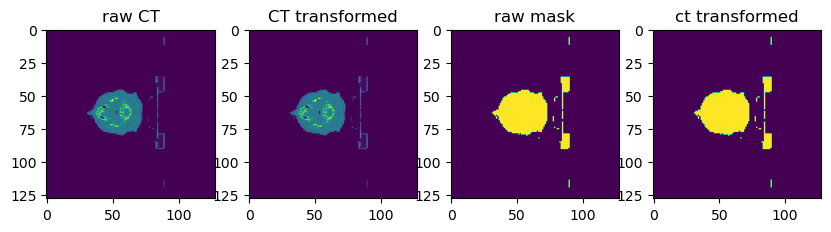

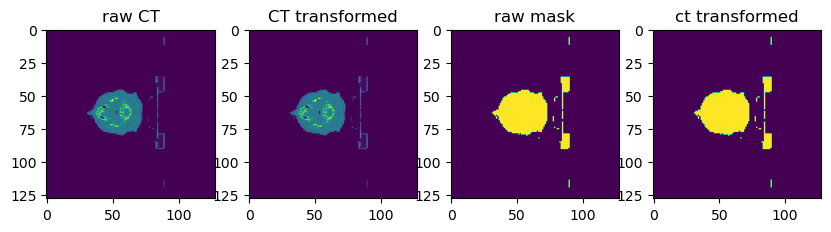

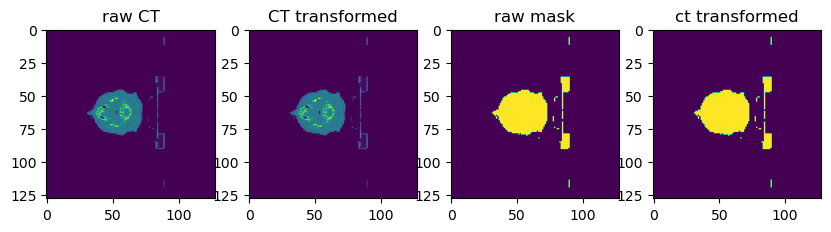

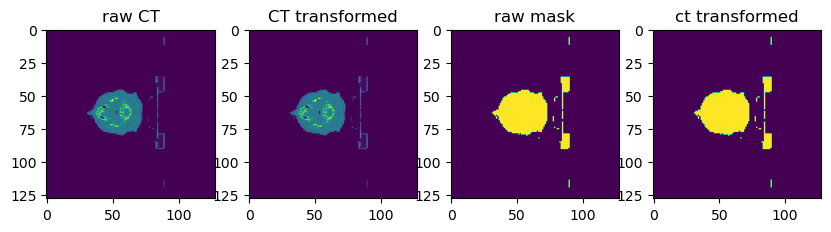

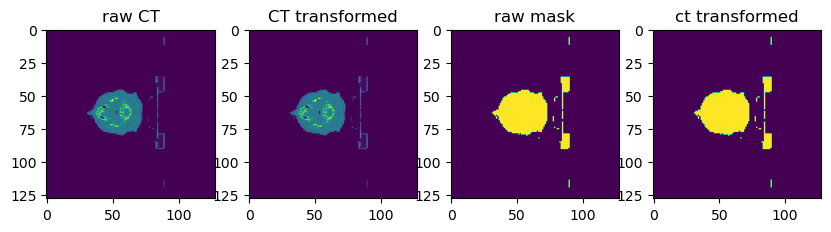

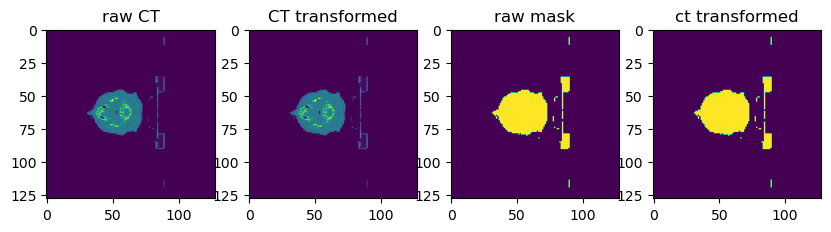

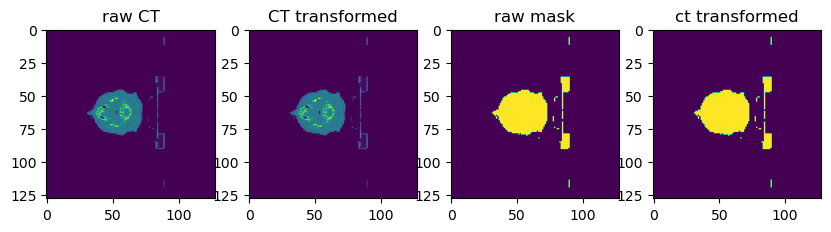

In [61]:
# Image and mask 

for i in range(10):
    ct_path = files_path[index] / "ct.npy"
    mask_path = files_path[index] / "possible_dose_mask.npy"

    ct = np.load(ct_path)
    mask = np.load(mask_path)

    # Transformation
    transform = A.Compose(
        [
            A.Normalize(mean=[97.6], std=[314.5], max_pixel_value=255),
        ]
    )

    # Applying the transformations
    augmentations = transform(image=ct, masks=[mask])
    augmented_ct = augmentations["image"]
    augmented_masks = augmentations["masks"]

    fig, ax = plt.subplots(1,4,figsize=(10,10))
    ax[0].set_title("raw CT")
    ax[0].imshow(ct)
    ax[1].set_title("CT transformed")
    ax[1].imshow(augmented_ct)
    ax[2].set_title("raw mask")
    ax[2].imshow(mask)
    ax[3].set_title("ct transformed")
    ax[3].imshow(augmented_masks[0])

    plt.show()


### Put it in the get item of the dataset class

In [162]:
class DoseDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.samples = os.listdir(data_path)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = self.data_path + os.sep + self.samples[idx]
        ct_scan = np.load(sample_path + os.sep + 'ct.npy')
        possible_dose_mask = np.load(sample_path + os.sep + 'possible_dose_mask.npy')
        dose = torch.from_numpy(np.load(sample_path + os.sep + 'dose.npy')).float()
        structure_masks = np.load(sample_path + os.sep + 'structure_masks.npy')
        
        # 11x128x128
        combined_masks = [structure_mask for structure_mask in structure_masks]
        combined_masks.append(possible_dose_mask)
        if self.transform:    
            # Other transformations
            val_transformation = transform["others"]
            augmentations = self.transform(image=ct, masks=combined_masks)
            ct_scan = augmentations["image"]
            combined_masks = augmentations["masks"]
    
        combined_masks = np.stack(combined_masks, axis=0)

        input_image = torch.from_numpy(np.concatenate([ct_scan[np.newaxis, :, :], combined_masks], axis=0)).float()
        dose = dose.unsqueeze(0)

        return {'input_image': input_image, 'dose': dose}

train_transform = A.Compose(
        [
            A.Normalize(mean=[97.6], std=[314.5], max_pixel_value=255),
        ])    
val_transform = A.Compose(
        [
            A.Normalize(mean=[97.6], std=[314.5], max_pixel_value=255),
        ])    

train_dataset = DoseDataset(config.TRAIN_PATH, transform = transform)

In [163]:
np.load("/kaggle/working/MVA-Dose-Prediction/train/sample_4522" + os.sep + 'structure_masks.npy')[:10].shape

(10, 128, 128)

In [164]:
train_dataset[0]

(11, 128, 128)


{'input_image': tensor([[[-0.3103, -0.3103, -0.3103,  ..., -0.3103, -0.3103, -0.3103],
          [-0.3103, -0.3103, -0.3103,  ..., -0.3103, -0.3103, -0.3103],
          [-0.3103, -0.3103, -0.3103,  ..., -0.3103, -0.3103, -0.3103],
          ...,
          [-0.3103, -0.3103, -0.3103,  ..., -0.3103, -0.3103, -0.3103],
          [-0.3103, -0.3103, -0.3103,  ..., -0.3103, -0.3103, -0.3103],
          [-0.3103, -0.3103, -0.3103,  ..., -0.3103, -0.3103, -0.3103]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0